# Starting cluster

## Prerequisites
First, you need to install MPI, on windows use MS-MPI:
https://msdn.microsoft.com/en-us/library/bb524831(v=vs.85).aspx


## With a profile (not working)
In theory, you should be able to create a profile using
```
ipython profile create --parallel --profile=myprofile
```
and then set
```
c.IPClusterEngines.engine_launcher_class = 'MPIEngineSetLauncher'
```
in ```<IPYTHON-DIR>/profile_myprofile/ipcluster_config.py```. This should then enable you to start a cluster using
```
ipcluster start --profile=myprofile
```
or alternatively through the Clusters tab in Jupyter


## Without a profile (not working)
An alternative is to run
```
ipcluster start --engines=MPI
```


## Manual start (working)
This, however, does *not* work for me on Windows. What does work is the following:

Start a controller using
```
ipcontroller --ip='*'
```
and then start several engines using mpiexec:
```
mpiexec -n 4 ipengine --mpi
```

In [1]:
import ipyparallel

# attach to a running cluster
cluster = ipyparallel.Client()#profile='mpi')

print('profile:', cluster.profile)
print('Number of ids:', len(cluster.ids))
print("IDs:", cluster.ids) # Print process id numbers

profile: default
Number of ids: 4
IDs: [0, 1, 2, 3]


In [2]:
%%px

from mpi4py import MPI

comm = MPI.COMM_WORLD

print("Hello! I'm rank %d from %d running in total..." % (comm.rank, comm.size))

comm.Barrier()   # wait for everybody to synchronize _here_

[stdout:0] Hello! I'm rank 0 from 4 running in total...
[stdout:1] Hello! I'm rank 1 from 4 running in total...
[stdout:2] Hello! I'm rank 2 from 4 running in total...
[stdout:3] Hello! I'm rank 3 from 4 running in total...


In [3]:
%%px

from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

print("Starting")
# passing MPI datatypes explicitly
if rank == 0:
    data = numpy.arange(100, dtype='i')
    numpy.random.shuffle(data)
    comm.Send([data, MPI.INT], dest=1, tag=77)
    print("{0}: sent data to 1: {1}".format(rank, data))
elif rank == 1:
    data = numpy.empty(100, dtype='i')
    comm.Recv([data, MPI.INT], source=0, tag=77)
    print("{0}: received data from 0: {1}".format(rank, data))
else:
    print("{0}: idle".format(rank))

[stdout:0] 
Starting
0: sent data to 1: [72 15 76 64 65 38 95  9 93 19 42 48 30  7 46 35 59 81 68 47 20 70 91 80
 49 23  1 34 56 82 11 31 29 78 92 58 77 17 53 79 60 27 51  5 41 52 87 74
 86 54 33 39 83 73 12 66 40 55 44 84 26  6 50 21 97 71 62 37 90 57 89 43
 28  4 25 32 85 69  3 18 10  0 24 22 63 16 75 96 99 67  2 45 61 13 88 36
 14 94 98  8]
[stdout:1] 
Starting
1: received data from 0: [72 15 76 64 65 38 95  9 93 19 42 48 30  7 46 35 59 81 68 47 20 70 91 80
 49 23  1 34 56 82 11 31 29 78 92 58 77 17 53 79 60 27 51  5 41 52 87 74
 86 54 33 39 83 73 12 66 40 55 44 84 26  6 50 21 97 71 62 37 90 57 89 43
 28  4 25 32 85 69  3 18 10  0 24 22 63 16 75 96 99 67  2 45 61 13 88 36
 14 94 98  8]
[stdout:2] 
Starting
2: idle
[stdout:3] 
Starting
3: idle


In [4]:
%%px

#Lets have matplotlib "inline"
%matplotlib inline

#Python 2.7 compatibility
from __future__ import print_function

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
#import mpld3

import subprocess
import os
import gc
import datetime

import pycuda.driver as cuda

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

#Finally, import our simulator
from SWESimulators import Common, HLL2, PlotHelper

In [5]:
%%px 

import atexit
def exitfunc():
    #Clean up old context if any:
    if 'cuda_context' in globals():
        print("Cleaning up CUDA context!")
        global cuda_context
        del cuda_context
        gc.collect()
    else:
        print("No CUDA context available")
        gc.collect()
        
atexit.register(exitfunc)
exitfunc()
    
cuda_context = Common.CudaContext(verbose=True, blocking=False)

[stdout:0] 
No CUDA context available
CUDA version (9, 1, 0)
Driver version 9010
Using GeForce 840M
 => compute capability: (5, 0)
 => memory: 2048.0 MB
Created context <231790149408>
[stdout:1] 
No CUDA context available
CUDA version (9, 1, 0)
Driver version 9010
Using GeForce 840M
 => compute capability: (5, 0)
 => memory: 2048.0 MB
Created context <969490393648>
[stdout:2] 
No CUDA context available
CUDA version (9, 1, 0)
Driver version 9010
Using GeForce 840M
 => compute capability: (5, 0)
 => memory: 2048.0 MB
Created context <557075755584>
[stdout:3] 
No CUDA context available
CUDA version (9, 1, 0)
Driver version 9010
Using GeForce 840M
 => compute capability: (5, 0)
 => memory: 2048.0 MB
Created context <77307610272>


In [6]:
%%px

def gen_test_data(nx, ny, g, num_ghost_cells):
    width = 100.0
    height = 100.0
    dx = width / float(nx)
    dy = height / float(ny)

    x_center = dx*nx/2.0
    y_center = dy*ny/2.0
    
    h  = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    
    comm = MPI.COMM_WORLD

    #Create a gaussian "dam break" that will not form shocks
    size = width / 3.0
    dt = 10**10
    for j in range(-num_ghost_cells, ny+num_ghost_cells):
        for i in range(-num_ghost_cells, nx+num_ghost_cells):
            x = dx*(i+0.5) - x_center
            y = dy*(j+0.5) - y_center
            
            h[j+num_ghost_cells, i+num_ghost_cells] = 0.5 + 0.1*(comm.rank + np.exp(-(x**2/size)))
            hu[j+num_ghost_cells, i+num_ghost_cells] = 0.1*np.exp(-(x**2/size))
    
    max_h_estimate = comm.rank* 0.1 + 0.6
    max_u_estimate = 0.1*2.0
    dt = min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))
    
    return h, hu, hv, dx, dy, dt

In [7]:
%%px

def sanity_check(variable, variable_name):
    maxval = np.amax(variable)
    minval = np.amin(variable)
    if (np.isnan(maxval) or np.isnan(minval)):
        print("=== WARNING ===")
        print(variable_name + " contains NaN values")
        print("=== WARNING ===")

def run_benchmark(simulator, courant_number, nx, ny, ghost_cells, g=9.81):
    h0, hu0, hv0, dx, dy, dt = gen_test_data(nx, ny, g, ghost_cells)
    dt = dt * courant_number

    #Initialize simulator
    with Common.Timer(simulator.__name__ + "_" + str(nx)) as timer:
        sim = simulator(cuda_context, \
                        h0, hu0, hv0, \
                        nx, ny, \
                        dx, dy, dt, \
                        g)

        t = sim.step(2.0)

        h, hu, hv = sim.download()

        h = h[ghost_cells, ghost_cells:-ghost_cells]
        hu = hu[ghost_cells, ghost_cells:-ghost_cells]
        hv = hv[ghost_cells, ghost_cells:-ghost_cells]

        sanity_check(h, "h")
        sanity_check(hu, "hu")
        sanity_check(hv, "hv")

        return [h, hu, hv]

[stdout:0] => HLL2_1024 5068.608284 ms
[stdout:1] => HLL2_1024 5038.588524 ms
[stdout:2] => HLL2_1024 5084.618568 ms
[stdout:3] => HLL2_1024 5121.647835 ms


[output:0]

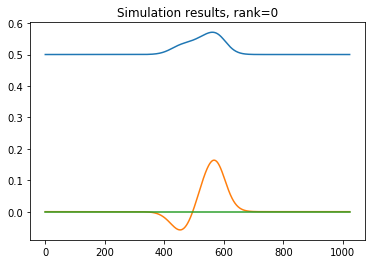

[output:1]

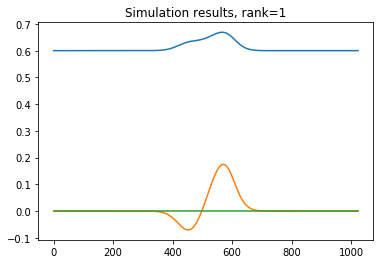

[output:2]

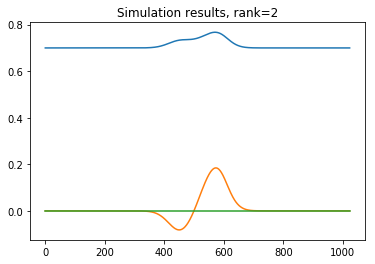

[output:3]

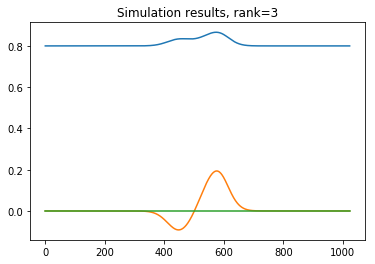

In [8]:
%%px

h, hu, hv = run_benchmark(simulator=HLL2.HLL2, \
              courant_number=0.95, \
              nx=1024, ny=1, \
              ghost_cells=2)

plt.figure()
plt.plot(h)
plt.plot(hu)
plt.plot(hv)
plt.title("Simulation results, rank=" + str(comm.rank))
plt.show()